In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# **Download and extract data from google drive**

dataset availabe in kaggle : https://www.kaggle.com/datasets/tapakah68/segmentation-full-body-mads-dataset

In [2]:
# Step 1: Install gdown if necessary
!pip install gdown

# Step 2: Download the file from Google Drive
import gdown

file_id = '1dluqnWNFgwC7QksHqyGSVN-5zVv3FJng'
download_url = f'https://drive.google.com/uc?export=download&id={file_id}'
gdown.download(download_url, 'segmentation-full-body-mads-dataset.zip', quiet=False)

# Step 3: Check the file type
!file segmentation-full-body-mads-dataset.zip

# Step 4: Extract the ZIP file
import zipfile

zip_file_path = 'segmentation-full-body-mads-dataset.zip'
extract_dir = 'extracted_data'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction completed.")

# Step 5: Verify the extracted files
import os

extracted_files = os.listdir(extract_dir)
print("Extracted files:", extracted_files)


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1dluqnWNFgwC7QksHqyGSVN-5zVv3FJng
From (redirected): https://drive.google.com/uc?export=download&id=1dluqnWNFgwC7QksHqyGSVN-5zVv3FJng&confirm=t&uuid=7b88675b-cfdf-46ff-b3d3-765049e55a1a
To: /content/segmentation-full-body-mads-dataset.zip
100%|██████████| 498M/498M [00:14<00:00, 34.2MB/s]

segmentation-full-body-mads-dataset.zip: Zip archive data, at least v4.5 to extract, compression method=deflate


Extraction completed.
Extracted files: ['df.csv', 'segmentation_full_body_mads_dataset_1192_img']


In [3]:
image_path = []

for root,dirs,files in os.walk('/content/extracted_data/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/images'):
    for file in sorted(files):
        path = os.path.join(root,file)
        image_path.append(path)

In [4]:
print(len(image_path))

1192


In [5]:
mask_path = []

for root,dirs,files in os.walk('/content/extracted_data/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/masks'):
    for file in sorted(files):
        path = os.path.join(root,file)
        mask_path.append(path)

In [6]:
len(mask_path)

1192

In [7]:
images = []
error_files = []
for path in tqdm(image_path):
    try:
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3, dtype=tf.uint8)
        images.append(img)
    except tf.errors.InvalidArgumentError as e:
        print(f"Error decoding image : {path}")
        error_files.append(path.split('/')[-1].strip('.jpg'))
        continue

100%|██████████| 1192/1192 [00:13<00:00, 91.67it/s]


In [8]:
len(error_files)

0

In [9]:
masks = []

for path in tqdm(mask_path):
    try:
        if(path.split('/')[-1].strip('.png') in error_files):
            continue
        msk = tf.io.read_file(path)
        msk = tf.image.decode_image(msk, channels=1, dtype=tf.uint8)
        masks.append(msk)
    except tf.errors.InvalidArgumentError as e:
        print(f"Error decoding image : {path}")
        continue

100%|██████████| 1192/1192 [00:04<00:00, 255.43it/s]


In [10]:
test_images = images[1042: ]
test_masks = masks[1042: ]

# Plot some images

(-0.5, 511.5, 383.5, -0.5)

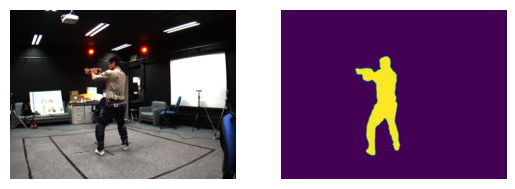

In [11]:
plt.subplot(1,2,1)
plt.imshow(test_images[0])
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(test_masks[0])
plt.axis(False)

In [12]:
len(masks)

1192

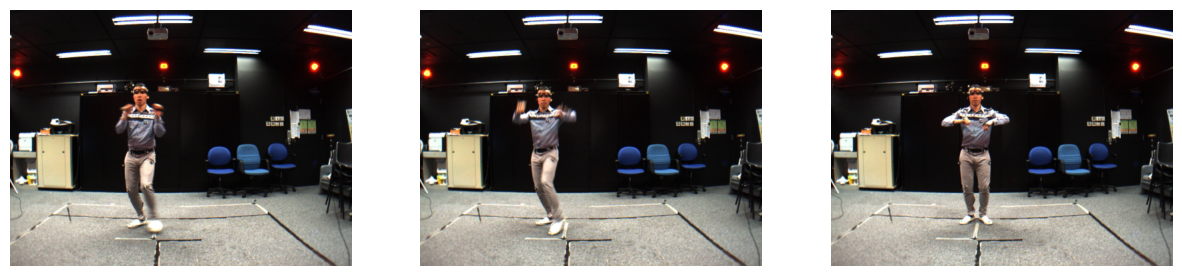

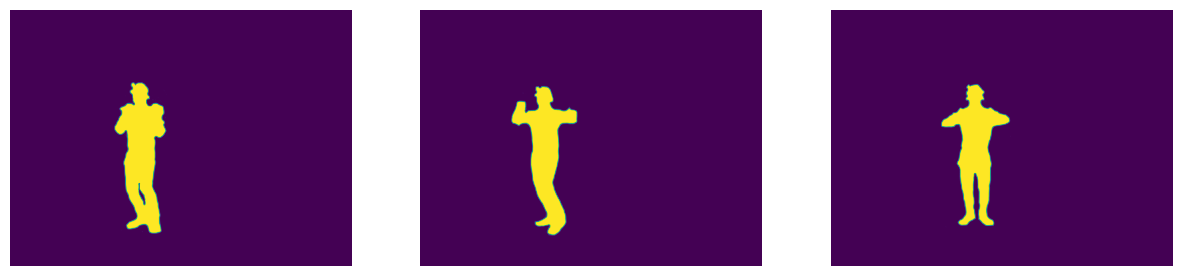

In [13]:
plt.figure(figsize = (15,6))

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(np.squeeze(images[i]))
    plt.axis(False)

plt.figure(figsize = (15,6))

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(masks[i])
    plt.axis(False)

In [14]:
images = images[:1042]
masks = masks[:1042]

In [15]:
len(images),len(masks)

(1042, 1042)

In [16]:
def resize_image(image):
    image = np.squeeze(image)
    image = tf.cast(image, dtype = tf.float32)
    image = image/255.
    image = tf.image.resize(image, (128,128))
    return image

In [17]:
def resize_mask(mask):
    mask = tf.cast(mask, dtype = tf.float32)
    mask = mask/255.
    mask = tf.image.resize(mask, (128,128))
    return mask

In [18]:
X = [resize_image(i) for i in images]
y = [resize_mask(i) for i in masks]

In [19]:
len(X), len(y)

(1042, 1042)

# Split the data train and validation

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.2, random_state=0)

print('X_train: ', len(X_train))
print('X_val: ', len(X_val))
print('y_train: ', len(y_train))
print('y_val: ', len(y_val))

X_train:  833
X_val:  209
y_train:  833
y_val:  209


# **Augmentation**

In [21]:
def brightness(image,mask):
    img = tf.image.adjust_brightness(image, 0.1)
    return img,mask

def gamma(image,mask):
    img = tf.image.adjust_gamma(image, 0.1)
    return img,mask

def hue(image,mask):
    img = tf.image.adjust_hue(image, -0.1)
    return img,mask

In [22]:
def crop(image, mask):
    img = tf.image.central_crop(image,0.7)
    img = tf.image.resize(img, (128,128))
    mask = tf.image.central_crop(mask, 0.7)
    mask = tf.image.resize(mask, (128,128))
    return img, mask

def flip_horizontal(image,mask):
    img = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)
    return img, mask

def flip_vertical(image, mask):
    img = tf.image.flip_up_down(image)
    mask = tf.image.flip_up_down(mask)
    return img, mask

def rotate(image, mask):
    img = tf.image.rot90(image)
    mask = tf.image.rot90(mask)
    return img, mask

#  Converting NumPy arrays (X_train, X_val, y_train, y_val) into TensorFlow Dataset objects

In [23]:
X_train = tf.data.Dataset.from_tensor_slices(X_train)
X_val = tf.data.Dataset.from_tensor_slices(X_val)
y_train = tf.data.Dataset.from_tensor_slices(y_train)
y_val = tf.data.Dataset.from_tensor_slices(y_val)

In [24]:
train = tf.data.Dataset.zip(X_train, y_train)
val = tf.data.Dataset.zip(X_val, y_val)

In [25]:
sample = list(train.as_numpy_iterator())
img = []
msk = []
for i,j in sample:
    img.append(i)
    msk.append(j)

In [26]:
sample = list(val.as_numpy_iterator())
val_img = []
val_msk = []
for i,j in sample:
    val_img.append(i)
    val_msk.append(j)

In [27]:
train_augmented = tf.data.Dataset.zip(X_train, y_train)

In [28]:
a = train_augmented.map(brightness)
b = train_augmented.map(gamma)
c = train_augmented.map(hue)
d = train_augmented.map(crop)
e = train_augmented.map(flip_horizontal)
f = train_augmented.map(flip_vertical)
g = train_augmented.map(rotate)
train_augmented = train_augmented.concatenate(a)
train_augmented = train_augmented.concatenate(b)
train_augmented = train_augmented.concatenate(c)
train_augmented = train_augmented.concatenate(d)
train_augmented = train_augmented.concatenate(e)
train_augmented = train_augmented.concatenate(f)

In [29]:
sample = list(train_augmented.as_numpy_iterator())
train_img_augmented = []
train_msk_augmented = []
for i,j in sample:
    train_img_augmented.append(i)
    train_msk_augmented.append(j)

In [30]:
train_img_augmented = np.array(train_img_augmented)
train_msk_augmented = np.array(train_msk_augmented)

In [31]:
train_img_augmented.shape

(5831, 128, 128, 3)

In [32]:
train_msk_augmented.shape

(5831, 128, 128, 1)

In [33]:
val_img = np.array(val_img)
val_img.shape

(209, 128, 128, 3)

In [34]:
val_msk = np.array(val_msk)
val_msk.shape

(209, 128, 128, 1)

# **Define the model U-Net architecture**

In [35]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input,UpSampling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras import backend as keras

def unet(input_size = (128,128,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2DTranspose(512,2,strides=(2,2),padding='same')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(256,2,strides=(2,2),padding='same')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(128,2,strides=(2,2),padding='same')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2DTranspose(64,2,strides=(2,2),padding='same')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [36]:
model_augmented = unet()

# **Training**

In [37]:
# Check if train_img_augmented and train_msk_augmented are single tensors
train_img_augmented = tf.concat(train_img_augmented, axis=0)

# Fit the model with the single tensors
model_augmented.fit(train_img_augmented, train_msk_augmented,
          batch_size = 32,
          epochs=3,
          validation_data=(val_img,val_msk))

Epoch 1/3
183/183 [==============================] - 138s 536ms/step - loss: 0.1224 - accuracy: 0.9400 - val_loss: 0.0615 - val_accuracy: 0.9536
Epoch 2/3
183/183 [==============================] - 81s 442ms/step - loss: 0.0471 - accuracy: 0.9620 - val_loss: 0.0275 - val_accuracy: 0.9769
Epoch 3/3
183/183 [==============================] - 82s 447ms/step - loss: 0.0284 - accuracy: 0.9680 - val_loss: 0.0250 - val_accuracy: 0.9771


In [38]:
img = np.array(img)
msk = np.array(msk)

In [39]:
print("Shape of img:", img.shape)
print("Shape of msk:", msk.shape)

Shape of img: (833, 128, 128, 3)
Shape of msk: (833, 128, 128, 1)


In [40]:
train_loss ,train_acc = model_augmented.evaluate(img,msk)
val_loss ,val_acc = model_augmented.evaluate(val_img,val_msk)
print("Training loss = %.2f" % train_loss)
print("Training accuracy = %.2f "% train_acc)

print("Validation loss = %.2f "%val_loss)
print("Validation accuracy = %.2f "% val_acc)

7/7 [==============================] - 1s 110ms/step - loss: 0.0250 - accuracy: 0.9771
Training loss = 0.02
Training accuracy = 0.97 
Validation loss = 0.03 
Validation accuracy = 0.98 


In [41]:
test_img = [resize_image(i) for i in test_images]
test_img = np.array(test_img)
test_img.shape

(150, 128, 128, 3)

In [42]:
test_msk = [resize_mask(i) for i in test_masks]
test_msk = np.array(test_msk)
test_msk.shape

(150, 128, 128, 1)

In [43]:
y_pred = model_augmented.predict(test_img)

5/5 [==============================] - 6s 1s/step


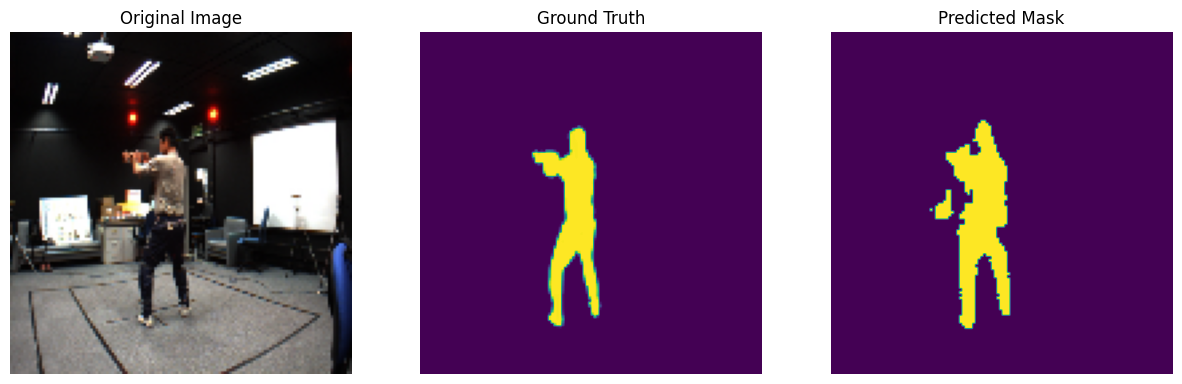

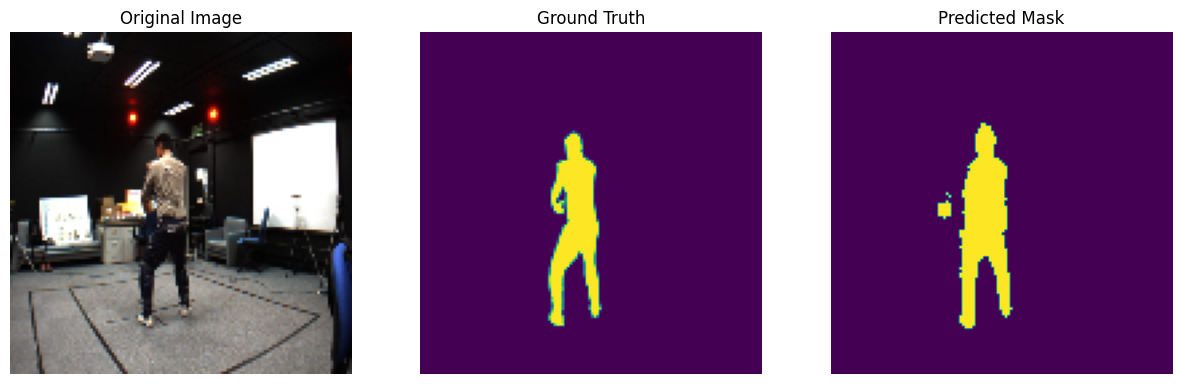

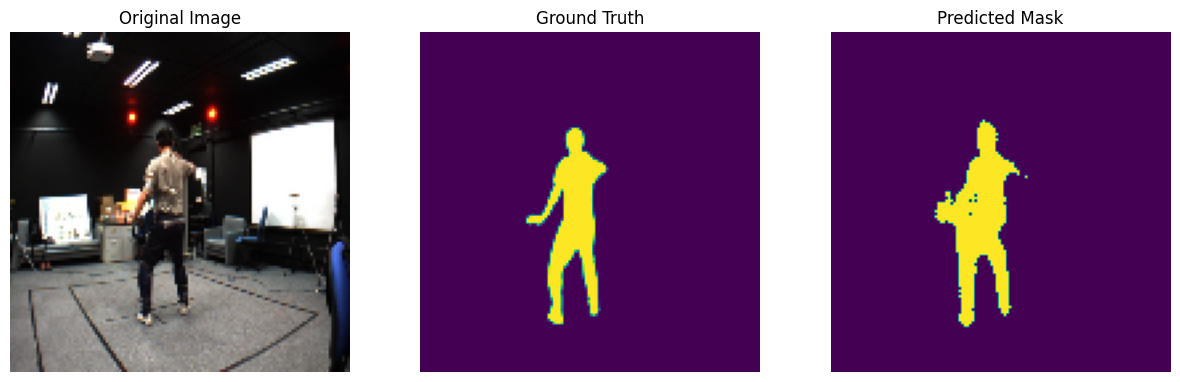

In [44]:
for i in range(3):

    plt.figure(figsize=(15,15))

    plt.subplot(i+1,3,1)
    plt.title("Original Image")
    plt.imshow(test_img[i])
    plt.axis(False)

    plt.subplot(i+1,3,2)
    plt.title("Ground Truth")
    plt.imshow(test_msk[i])
    plt.axis(False)

    plt.subplot(i+1,3,3)
    plt.title("Predicted Mask")
    plt.imshow(tf.round(y_pred[i]))
    plt.axis(False)